# Part 3 -- Exploratory Data Analysis (EDA)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sqlite3

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

## Load merged DB data to a Pandas DataFrame

In [2]:
con = sqlite3.connect(os.path.join('data', 'combined_data.db'))
cur = con.cursor()

In [3]:
res = cur.execute("""
    SELECT * FROM sqlite_master
""")

for c in cur.fetchall():
    print(c)

('table', 'CompanyClassification', 'CompanyClassification', 2, 'CREATE TABLE "CompanyClassification" (\n"Category" TEXT,\n  "Website" TEXT,\n  "CompanyName" TEXT,\n  "homepage_text" TEXT,\n  "h1" TEXT,\n  "h2" TEXT,\n  "h3" TEXT,\n  "nav_link_text" TEXT,\n  "meta_keywords" TEXT,\n  "meta_description" TEXT\n)')
('table', 'CompanyDataset', 'CompanyDataset', 110723, 'CREATE TABLE "CompanyDataset" (\n"Unnamed: 0" INTEGER,\n  "CompanyName" TEXT,\n  "Website" TEXT,\n  "year founded" REAL,\n  "industry" TEXT,\n  "size range" TEXT,\n  "locality" TEXT,\n  "country" TEXT,\n  "linkedin url" TEXT,\n  "current employee estimate" INTEGER,\n  "total employee estimate" INTEGER\n)')
('index', 'employees', 'CompanyDataset', 416224, 'CREATE INDEX employees ON CompanyDataset (`current employee estimate`)')
('index', 'countries', 'CompanyDataset', 409796, 'CREATE INDEX countries ON CompanyDataset (`country`)')
('table', 'Company', 'Company', 397909, 'CREATE TABLE "Company" (\n"Unnamed: 0" INTEGER,\n  "Comp

In [4]:
df = pd.read_sql_query("""SELECT * FROM Company;""", con)

In [5]:
cur.close()
con.close()

## Exploratory Data Analysis

In [6]:
df.columns

Index(['Unnamed: 0', 'CompanyName', 'Website', 'year founded', 'industry',
       'size range', 'locality', 'country', 'linkedin url',
       'current employee estimate', 'total employee estimate', 'Category',
       'homepage_text', 'h1', 'h2', 'h3', 'nav_link_text', 'meta_keywords',
       'meta_description'],
      dtype='object')

### Remove unnecessary DB index column

In [7]:
df = df.drop(columns=['Unnamed: 0'])

### Convert column names to lowercase and remove whitespaces replacing them with underscores

In [8]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df = df.rename(columns={'companyname': 'company_name'})

In [9]:
# Replace empty / whitespace strings with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

### Perform some basic feature checks

In [10]:
# Gets additional value such as min / median / max etc.
def column_summary_plus(df: pd.DataFrame):
    result_df = pd.DataFrame(
        data=[], 
        columns=[
            'col_name', 'col_dtype', 'num_distinct_values', 'min_value', 'max_value', 
            'median_no_na', 'average_no_na','average_non_zero', 'null_present', 
            'nulls_num', 'non_nulls_num', 'distinct_values'
        ]
    )
    
    new_data = []
    
    # Loop through each column in the DataFrame
    for column in df.columns:
        print(f"Start processing {column} col with {df[column].dtype} dtype")
        # Get column dtype
        col_dtype = df[column].dtype
        # Get distinct values and their counts
        value_counts = df[column].value_counts()
        distinct_values = value_counts.index.tolist()
        # Get number of distinct values
        num_distinct_values = len(distinct_values)

        if np.issubdtype(df[column].dtype, np.number):
            # Get min and max values
            sorted_values = sorted(distinct_values)
            min_value = sorted_values[0] if sorted_values else None
            max_value = sorted_values[-1] if sorted_values else None

            # Get median value
            non_distinct_val_list = sorted(df[column].dropna().tolist())
            len_non_d_list = len(non_distinct_val_list)
            if len(non_distinct_val_list) == 0:
                median = None
            else:
                median = non_distinct_val_list[len_non_d_list//2]

            # Get average value if value is number
            if len(non_distinct_val_list) > 0:
                average = sum(non_distinct_val_list)/len_non_d_list
                non_zero_val_list = [v for v in non_distinct_val_list if v > 0]
                average_non_zero = sum(non_zero_val_list)/len_non_d_list
            else:
                average = None
                average_non_zero = None
        else:
            min_value = 'N/A'
            max_value = 'N/A'
            median = 'N/A'
            average = 'N/A'
            average_non_zero = 'N/A'

        # Get number of nulls and non-nulls
        num_nulls = df[column].isnull().sum()
        num_non_nulls = df[column].notnull().sum()

        # Distinct_values only take top 10 distinct values count
        top_10_d_v = value_counts.head(10).index.tolist()
        top_10_c = value_counts.head(10).tolist()
        top_10_d_v_dict = dict(zip(top_10_d_v,top_10_c))

        # Append the information to the new data list
        new_data.append({
            'col_name': column, 'col_dtype': col_dtype, 'num_distinct_values': num_distinct_values, 
            'min_value': min_value, 'max_value': max_value, 'median_no_na': median, 
            'average_no_na': average, 'average_non_zero': average_non_zero, 'nulls_num': num_nulls, 
            'non_nulls_num': num_non_nulls, 'distinct_values': top_10_d_v_dict
        })

    # Append the information to the result DataFrame
    result_df = pd.concat(objs=[result_df, pd.DataFrame(data=new_data)], ignore_index=True)
        
    return result_df


summary_df = column_summary_plus(df)
display(summary_df)

Start processing company_name col with object dtype
Start processing website col with object dtype
Start processing year_founded col with float64 dtype
Start processing industry col with object dtype
Start processing size_range col with object dtype
Start processing locality col with object dtype
Start processing country col with object dtype
Start processing linkedin_url col with object dtype
Start processing current_employee_estimate col with int64 dtype
Start processing total_employee_estimate col with int64 dtype
Start processing category col with object dtype
Start processing homepage_text col with object dtype
Start processing h1 col with object dtype
Start processing h2 col with object dtype
Start processing h3 col with object dtype
Start processing nav_link_text col with object dtype
Start processing meta_keywords col with object dtype
Start processing meta_description col with object dtype


,col_name,col_dtype,num_distinct_values,min_value,max_value,median_no_na,average_no_na,average_non_zero,null_present,nulls_num,non_nulls_num,distinct_values
0,company_name,object,5451314,N/A,N/A,N/A,N/A,N/A,NaN,0,5522803,"{'independent consultant': 40, 'private practi..."
1,website,object,5474762,N/A,N/A,N/A,N/A,N/A,NaN,0,5522803,"{'nordalps.com': 12, 'play-cricket.com': 8, 'v..."
2,year_founded,float64,232,1451.0,2103.0,2009.0,2001.904919,2001.904919,NaN,2175920,3346883,"{2015.0: 219441, 2014.0: 218255, 2013.0: 20907..."
3,industry,object,148,N/A,N/A,N/A,N/A,N/A,NaN,112775,5410028,{'information technology and services': 369512...
4,size_range,object,8,N/A,N/A,N/A,N/A,N/A,NaN,0,5522803,"{'1 - 10': 4130680, '11 - 50': 988537, '51 - 2..."
5,locality,object,90186,N/A,N/A,N/A,N/A,N/A,NaN,1693997,3828806,"{'london, greater london, united kingdom': 690..."
6,country,object,236,N/A,N/A,N/A,N/A,N/A,NaN,1566173,3956630,"{'united states': 1767278, 'united kingdom': 3..."
7,linkedin_url,object,5522803,N/A,N/A,N/A,N/A,N/A,NaN,0,5522803,"{'linkedin.com/company/ibm': 1, 'linkedin.com/..."
8,current_employee_estimate,int64,5189,0,274047,2,16.103707,16.103707,NaN,0,5522803,"{1: 1776865, 0: 950542, 2: 789268, 3: 418838, ..."
9,total_employee_estimate,int64,8223,1,716906,3,37.502976,37.502976,NaN,0,5522803,"{1: 1740935, 2: 862262, 3: 491918, 4: 325942, ..."


In [11]:
summary_df = column_summary_plus(df.dropna(subset=['category']))
display(summary_df)

Start processing company_name col with object dtype
Start processing website col with object dtype
Start processing year_founded col with float64 dtype
Start processing industry col with object dtype
Start processing size_range col with object dtype
Start processing locality col with object dtype
Start processing country col with object dtype
Start processing linkedin_url col with object dtype
Start processing current_employee_estimate col with int64 dtype
Start processing total_employee_estimate col with int64 dtype
Start processing category col with object dtype
Start processing homepage_text col with object dtype
Start processing h1 col with object dtype
Start processing h2 col with object dtype
Start processing h3 col with object dtype
Start processing nav_link_text col with object dtype
Start processing meta_keywords col with object dtype
Start processing meta_description col with object dtype


,col_name,col_dtype,num_distinct_values,min_value,max_value,median_no_na,average_no_na,average_non_zero,null_present,nulls_num,non_nulls_num,distinct_values
0,company_name,object,73448,N/A,N/A,N/A,N/A,N/A,NaN,0,73448,"{'cognizant technology solutions': 1, 'shareop..."
1,website,object,73448,N/A,N/A,N/A,N/A,N/A,NaN,0,73448,"{'cognizant.com': 1, 'shareoptic.com': 1, 'mp-..."
2,year_founded,float64,199,1804.0,2018.0,2005.0,1996.834138,1996.834138,NaN,25830,47618,"{2010.0: 2201, 2014.0: 2122, 2012.0: 2070, 201..."
3,industry,object,107,N/A,N/A,N/A,N/A,N/A,NaN,0,73448,"{'information technology and services': 3449, ..."
4,size_range,object,8,N/A,N/A,N/A,N/A,N/A,NaN,0,73448,"{'1 - 10': 50783, '11 - 50': 15404, '51 - 200'..."
5,locality,object,11012,N/A,N/A,N/A,N/A,N/A,NaN,1724,71724,"{'london, greater london, united kingdom': 156..."
6,country,object,7,N/A,N/A,N/A,N/A,N/A,NaN,0,73448,"{'united states': 48615, 'united kingdom': 115..."
7,linkedin_url,object,73448,N/A,N/A,N/A,N/A,N/A,NaN,0,73448,"{'linkedin.com/company/cognizant': 1, 'linkedi..."
8,current_employee_estimate,int64,908,0,122031,2,27.645926,27.645926,NaN,0,73448,"{1: 19505, 2: 10226, 0: 8114, 3: 6155, 4: 4177..."
9,total_employee_estimate,int64,1320,1,210020,4,59.457317,59.457317,NaN,0,73448,"{1: 17381, 2: 9824, 3: 6270, 4: 4379, 5: 3241,..."


### Explore missing values

### Original dataset

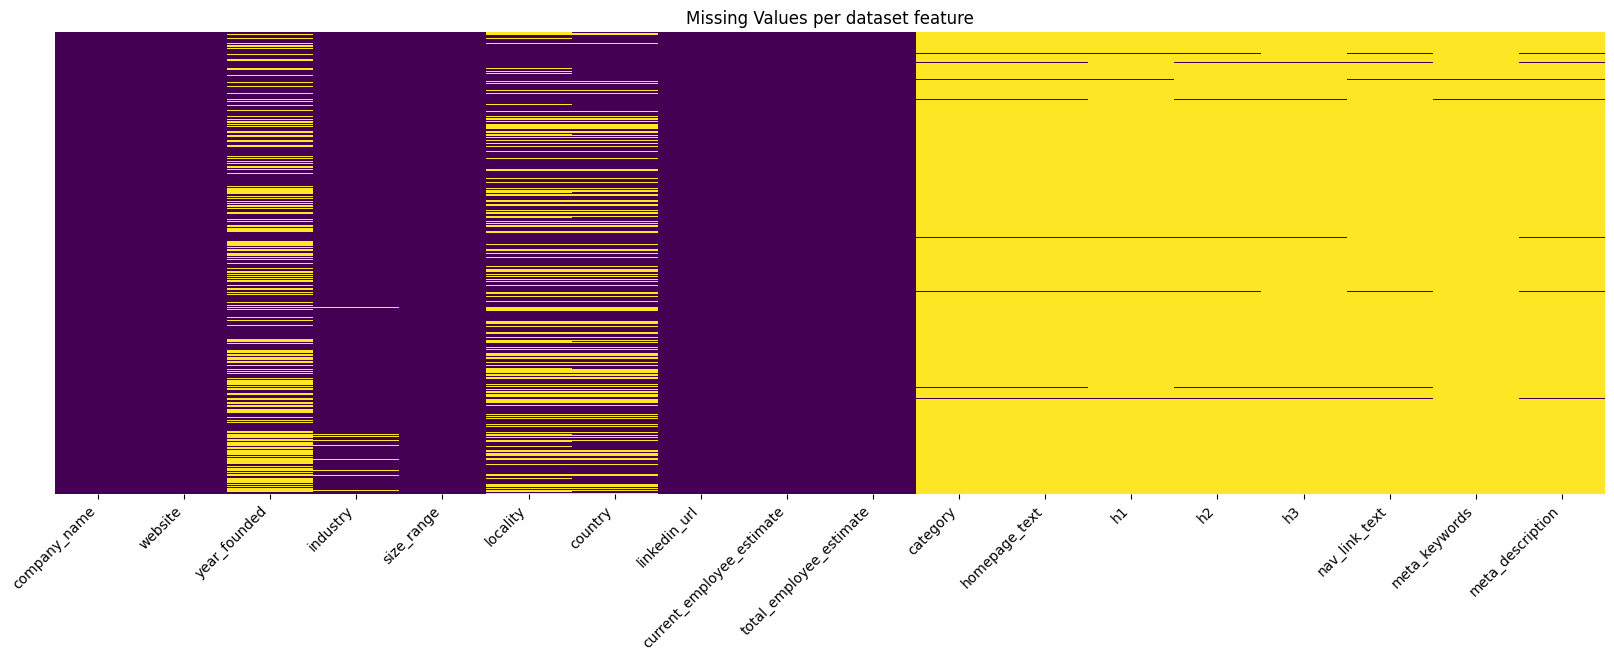

In [12]:
plt.figure(figsize=(20, 6))

plot = sns.heatmap(df.isna(), yticklabels=False, cbar=False, cmap='viridis')

# Get x-axis tick locations and labels
xtick_loc, xtick_labels = plt.xticks()

# Set the x-axis ticks
plot.set_xticks(ticks=xtick_loc, labels=xtick_labels, rotation=45, ha='right')

plt.title("Missing Values per dataset feature")
plt.show()

In [13]:
print("Dataset size:", len(df))
print("Number of rows with existing category values:", len(df.dropna(subset=['category'])))

Dataset size: 5522803
Number of rows with existing category values: 73448


### Reduced dataset

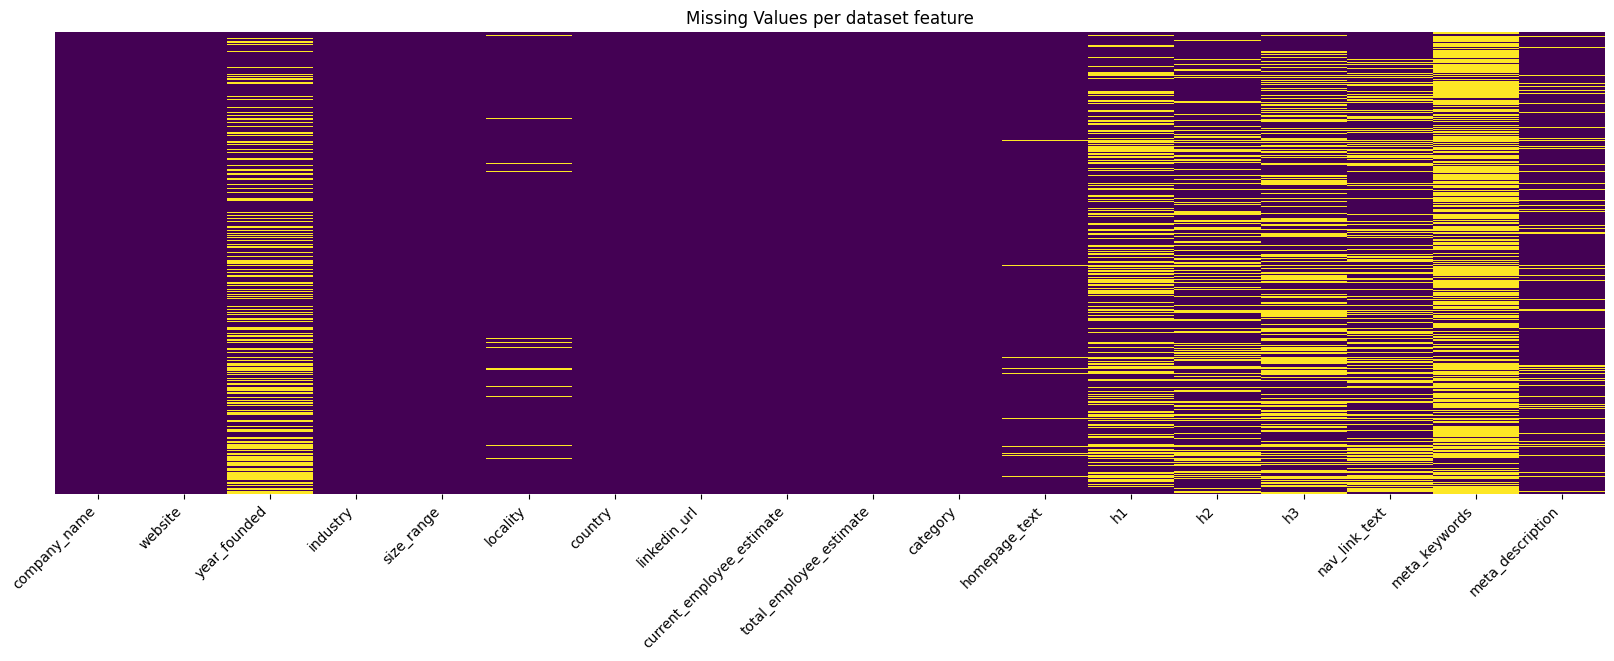

In [14]:
plt.figure(figsize=(20, 6))

plot = sns.heatmap(df.dropna(subset=['category']).isna(), yticklabels=False, cbar=False, cmap='viridis')

# Get x-axis tick locations and labels
xtick_loc, xtick_labels = plt.xticks()

# Set the x-axis ticks
plot.set_xticks(ticks=xtick_loc, labels=xtick_labels, rotation=45, ha='right')

plt.title("Missing Values per dataset feature")
plt.show()

In [15]:
df.dropna(subset=['category']).isna().mean()

company_name                 0.000000
website                      0.000000
year_founded                 0.351677
industry                     0.000000
size_range                   0.000000
locality                     0.023472
country                      0.000000
linkedin_url                 0.000000
current_employee_estimate    0.000000
total_employee_estimate      0.000000
category                     0.000000
homepage_text                0.017713
h1                           0.368492
h2                           0.280920
h3                           0.395300
nav_link_text                0.349240
meta_keywords                0.678902
meta_description             0.095428
dtype: float64

## Define a plot function for numeric and categorical features

In [15]:
def plot_histographs(df: pd.DataFrame, columns: list):    
    # Perform univariate analysis on numerical columns
    for column in columns:
        plt.figure(figsize=(20, 6))
        
        # For continuous variables
        if len(df[column].unique()) > 125:  # Assuming unique values > 20, consider the feature as continuous
            sns.histplot(data=df, x=column, kde=True, log_scale=True)
            plt.title(f'Histogram of {column} (log scale)')
            plt.ylabel('Frequency')
        else:  # For discrete or ordinal variables
            ax = sns.countplot(data=df, x=column)
            plt.title(f'Count of {column}')
            plt.ylabel('Count')
            
            # Annotate each bar with its count
            for p in ax.patches:
                ax.annotate(format(p.get_height(), '.0f'), 
                            (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha = 'center', va = 'center', 
                            xytext = (0, 5), 
                            textcoords = 'offset points')
        
        plt.xlabel(column)
        plt.xticks(rotation=90)
        plt.show()

## Perform exploration per feature type

In [16]:
# Identify useful numeric columns
num_cols = [c for c in list(df.select_dtypes(include=[np.number]).columns) if df[c].isna().mean() < 0.2]

# Useful categorical columns
cat_cols = ['country', 'industry', 'size_range']

# Useful text columns
text_cols = ['homepage_text', 'meta_description']

# Class / category column
label_col = 'category'

## Perform some category analysis

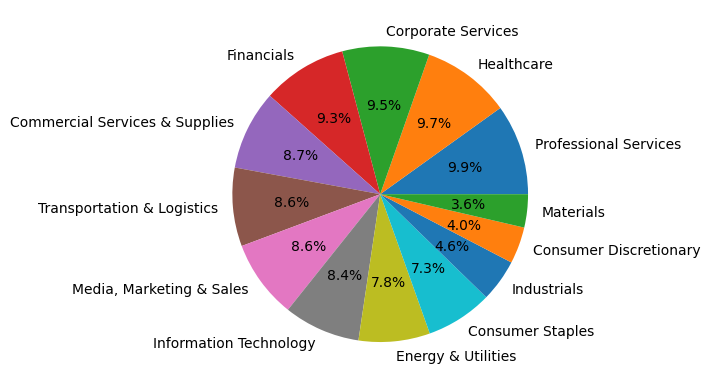

In [17]:
df_temp = df.dropna(subset=[label_col])
plt.pie(df_temp[label_col].value_counts(), labels=df_temp[label_col].value_counts().index.tolist(), autopct='%1.1f%%')
plt.show()

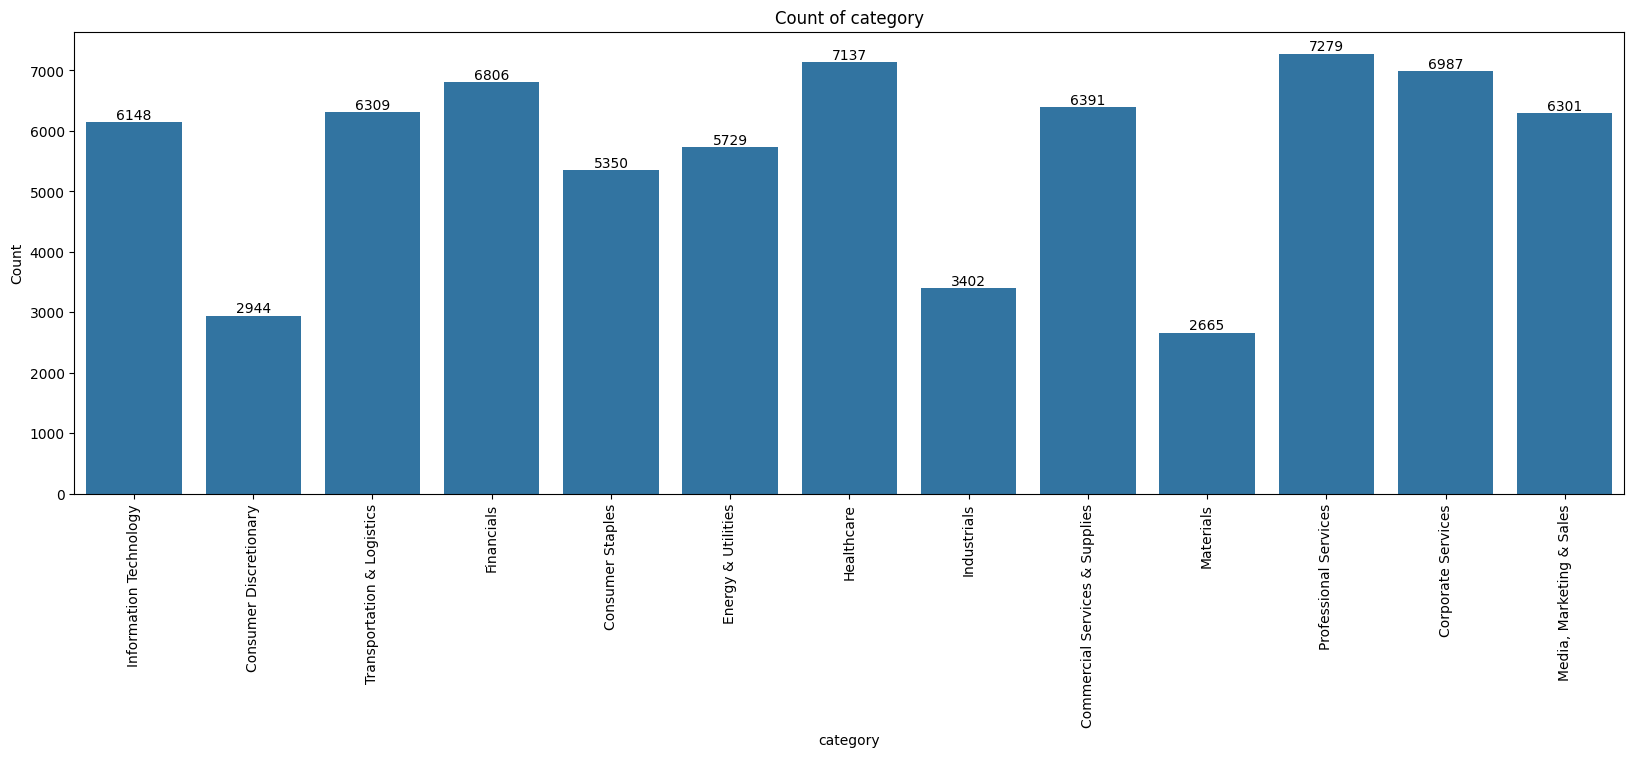

In [18]:
plot_histographs(df_temp, [label_col])

In [19]:
target_encoder = LabelEncoder()
target_encoder.fit(df_temp[label_col])

LabelEncoder()

### Explore numeric features

In [20]:
df_temp = df.dropna(subset=num_cols+[label_col])

for col in num_cols:
    df_temp[col] = pd.to_numeric(df_temp[col], errors='coerce').astype('int64')

/tmp/ipykernel_30383/62558195.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[col] = pd.to_numeric(df_temp[col], errors='coerce').astype('int64')
/tmp/ipykernel_30383/62558195.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[col] = pd.to_numeric(df_temp[col], errors='coerce').astype('int64')


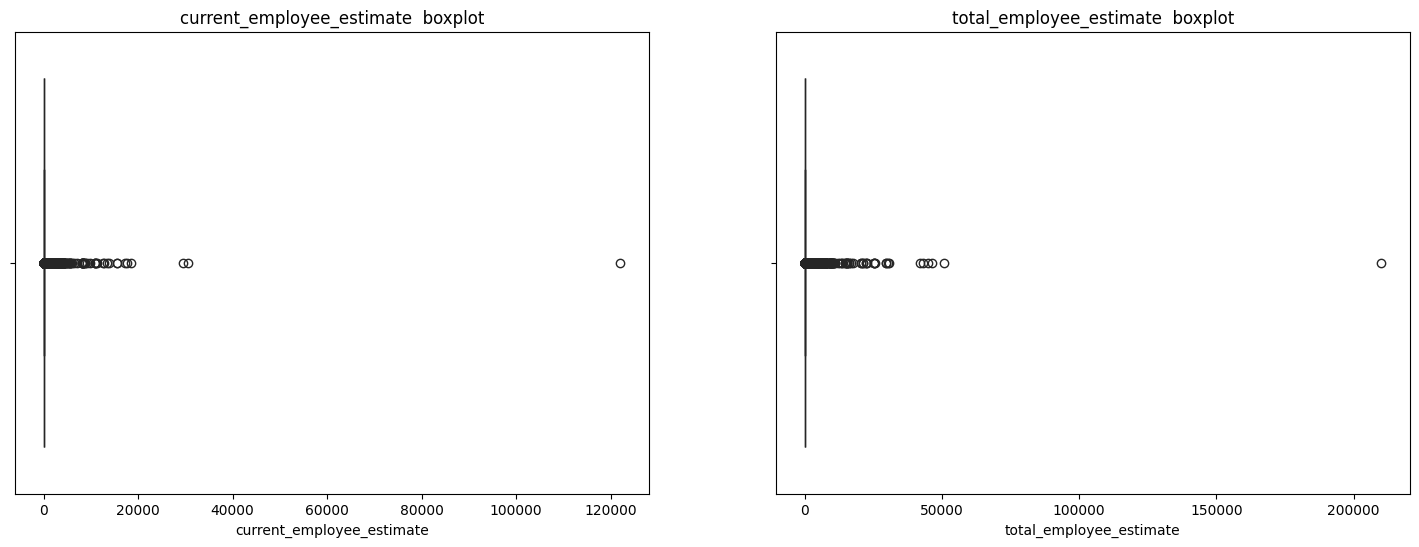

In [21]:
fig, axs = plt.subplots(ncols=len(num_cols), figsize=(18,6))

for i, feature in enumerate(num_cols):
    sns.boxplot(df_temp[num_cols], x=feature, ax=axs[i%len(num_cols)], color='purple').set(title=f'{feature}  boxplot')

plt.show()

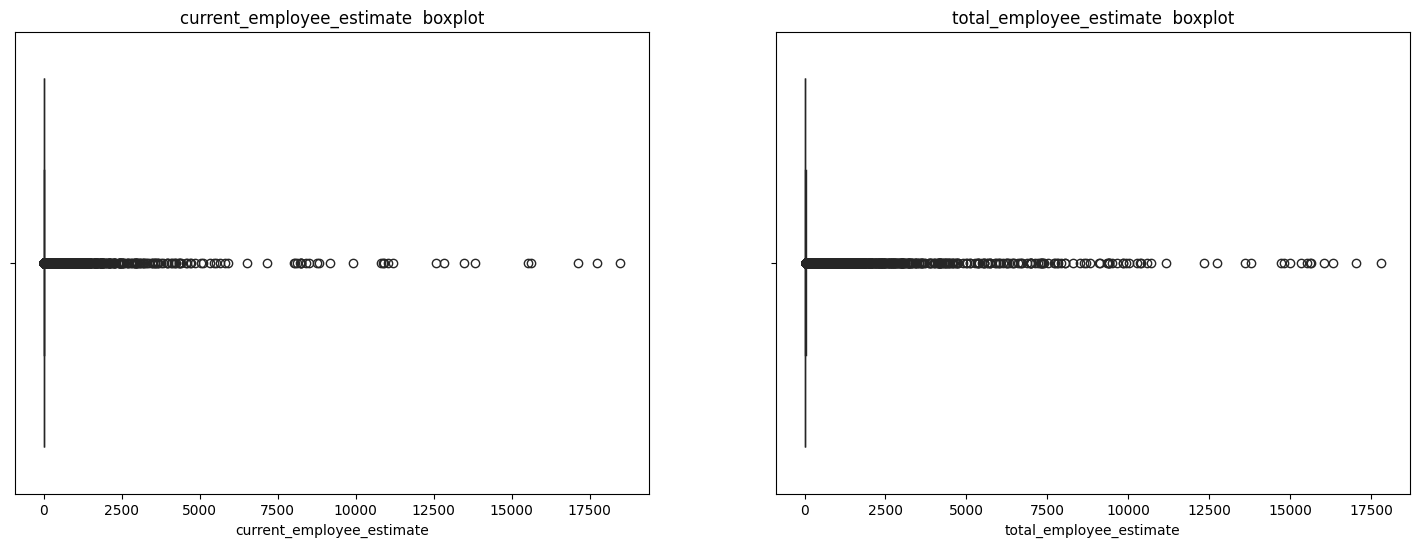

In [22]:
fig, axs = plt.subplots(ncols=len(num_cols), figsize=(18,6))

for i, feature in enumerate(num_cols):
    sns.boxplot(df_temp.loc[df_temp[feature] < 20000, [feature]], x=feature, ax=axs[i%len(num_cols)], color='purple').set(title=f'{feature}  boxplot')

plt.show()

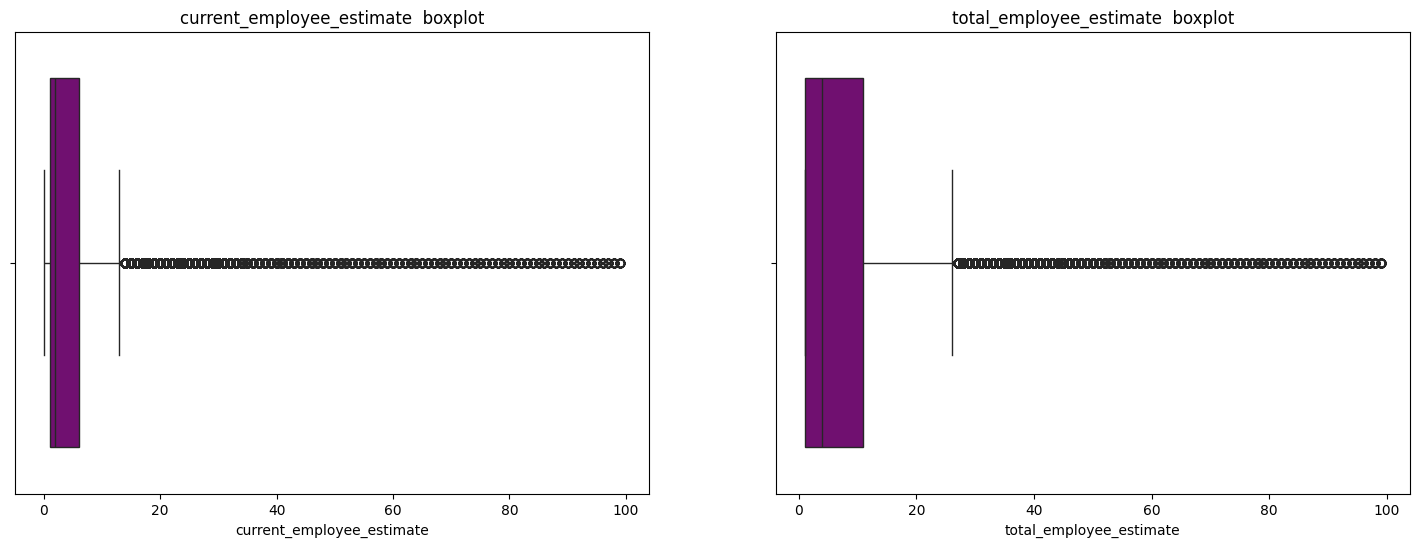

In [23]:
fig, axs = plt.subplots(ncols=len(num_cols), figsize=(18,6))

for i, feature in enumerate(num_cols):
    sns.boxplot(df_temp.loc[df_temp[feature] < 100, [feature]], x=feature, ax=axs[i%len(num_cols)], color='purple').set(title=f'{feature}  boxplot')

plt.show()

/tmp/ipykernel_30383/3536399849.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['label'] = target_encoder.transform(df_temp[label_col])


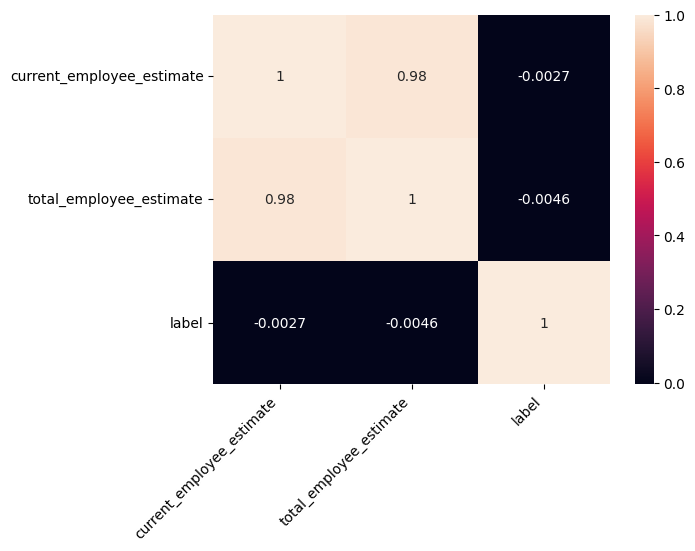

In [24]:
# Add category label to the temporary DataFrame to correlate
df_temp['label'] = target_encoder.transform(df_temp[label_col])

# Get features correlations
corr = df_temp[num_cols + ['label']].corr()

# Create correlation matrix as a heatmap
plot = sns.heatmap(corr, annot=True)

# Get x-axis tick locations and labels
xtick_loc, xtick_labels = plt.xticks()

# Set the x-axis ticks
plot.set_xticks(ticks=xtick_loc, labels=xtick_labels, rotation=45, ha='right')

plt.show()

/home/bishop/miniconda3/envs/dialectica/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


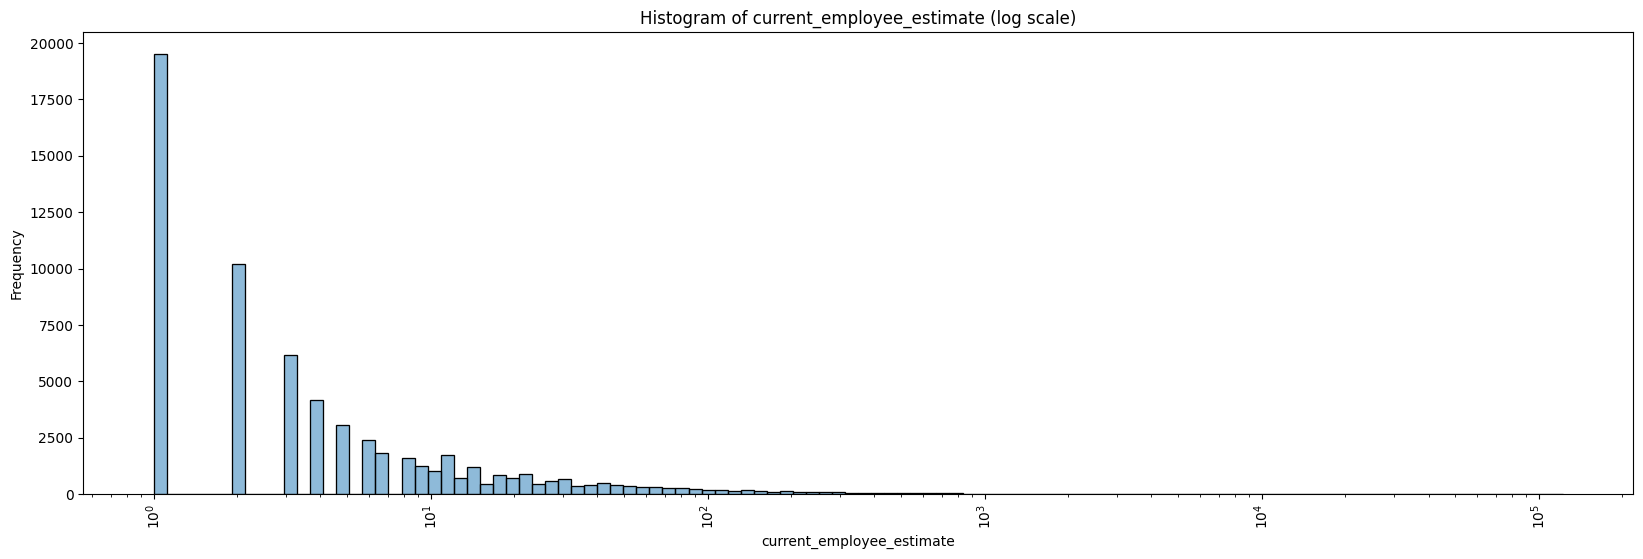

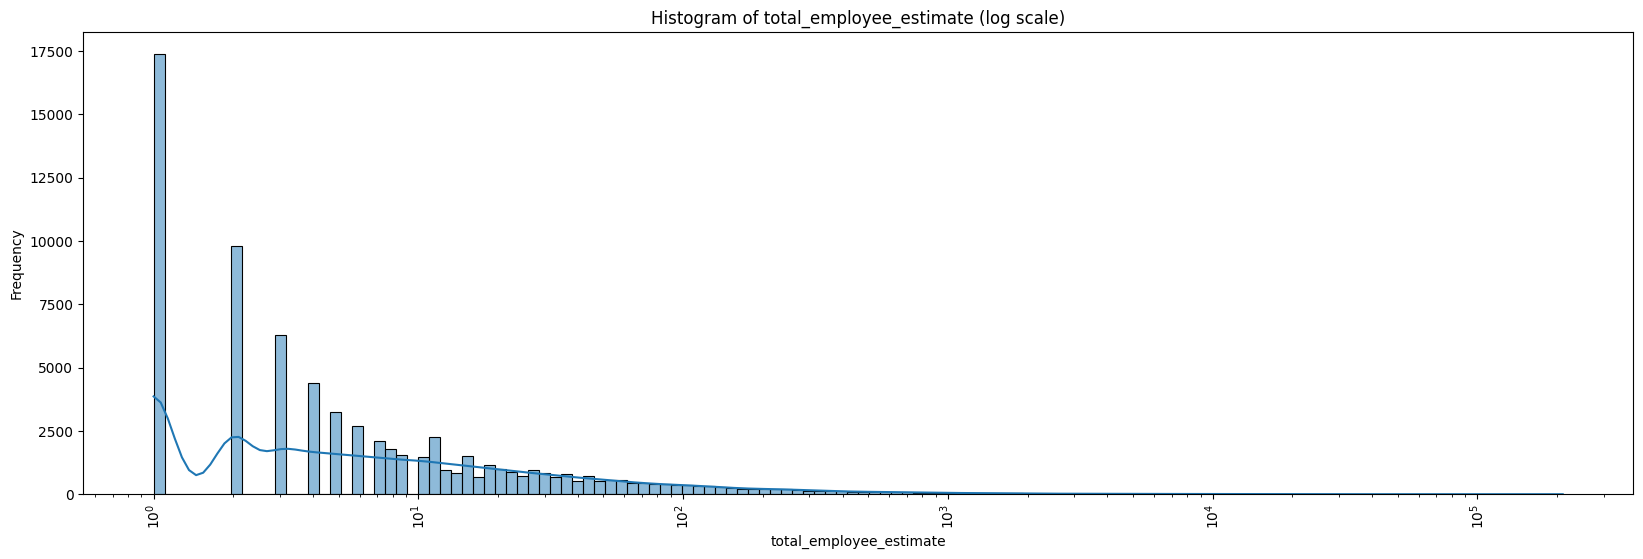

In [25]:
plot_histographs(df_temp, num_cols)

### Explore categorical features

In [26]:
df_temp = df.dropna(subset=cat_cols+[label_col])

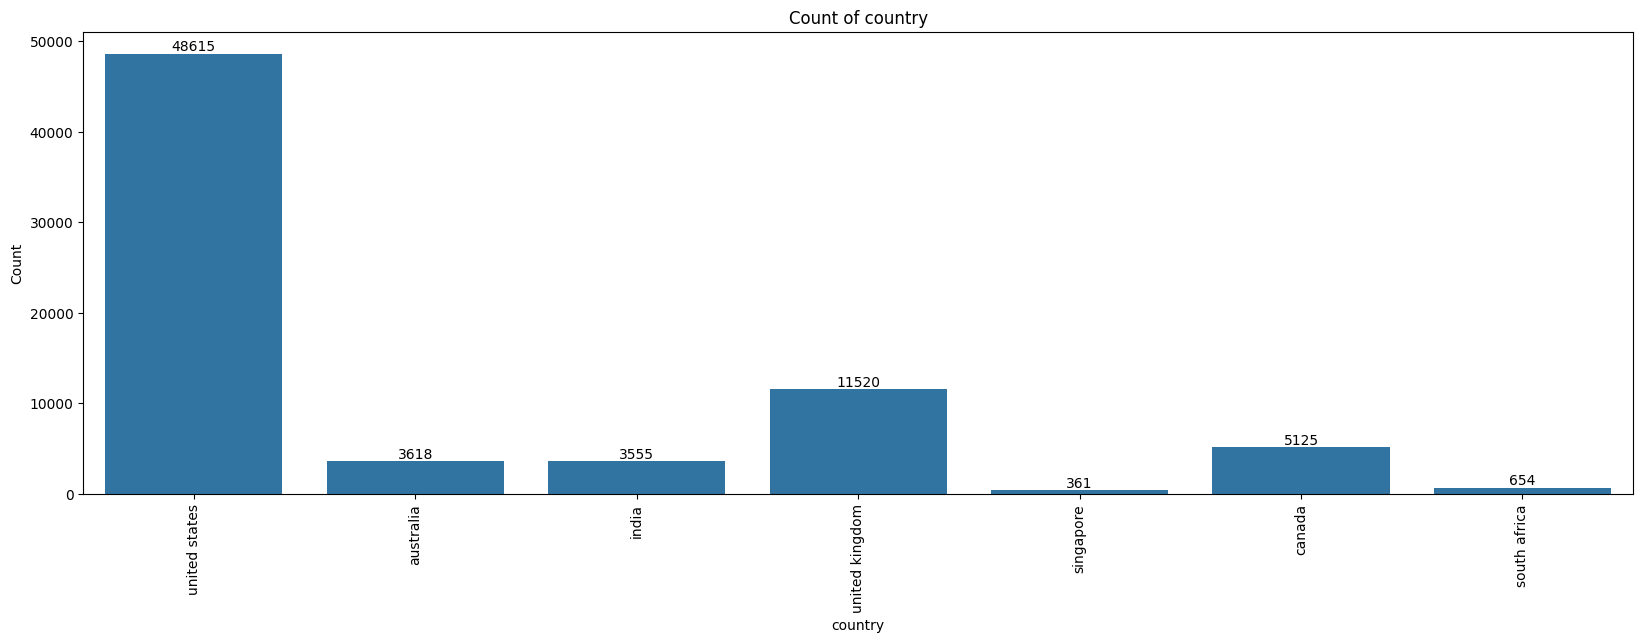

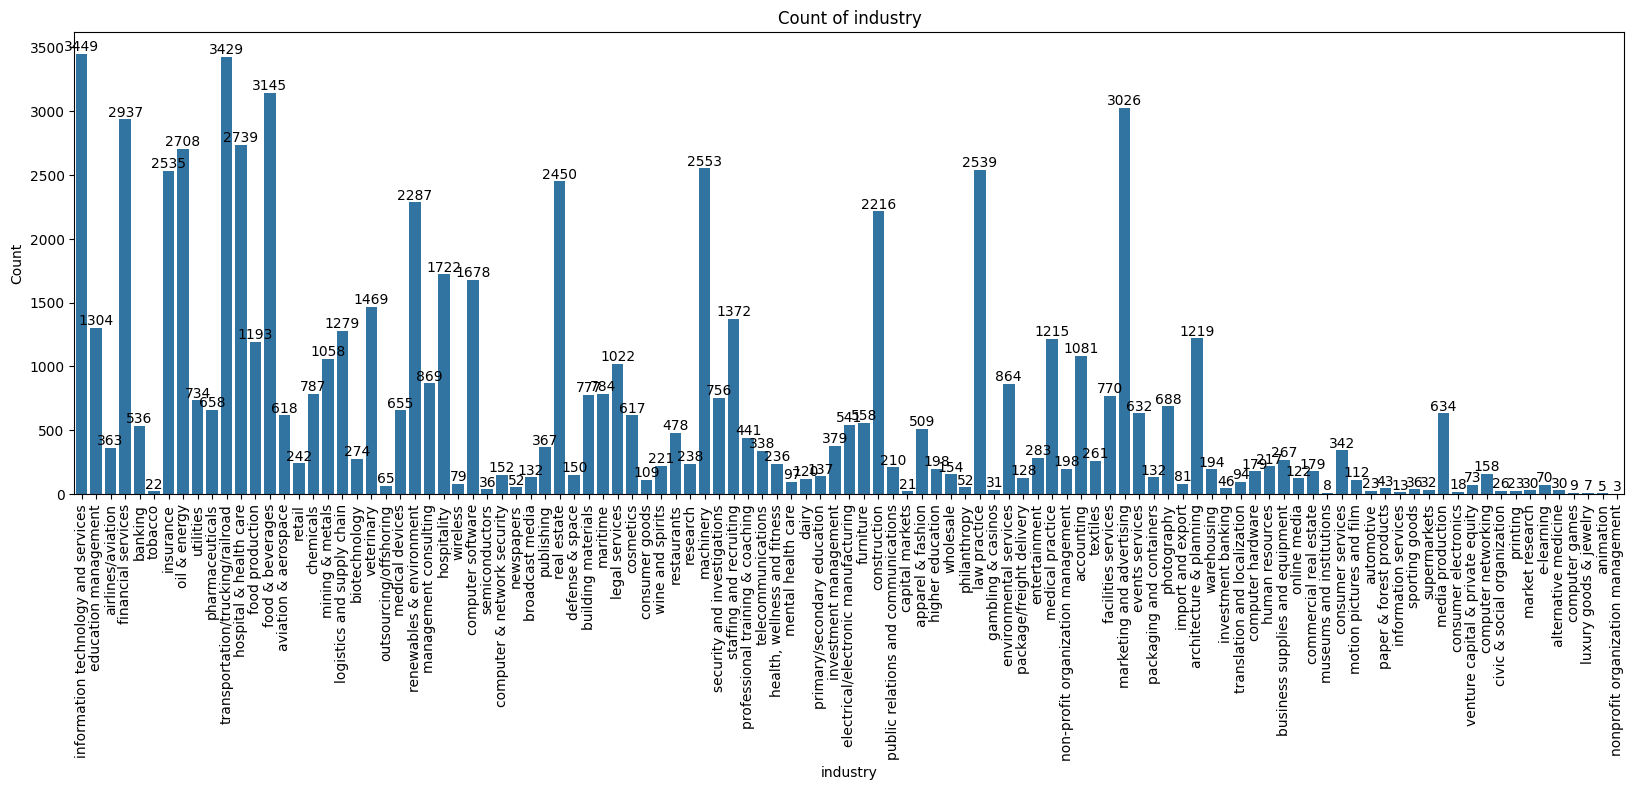

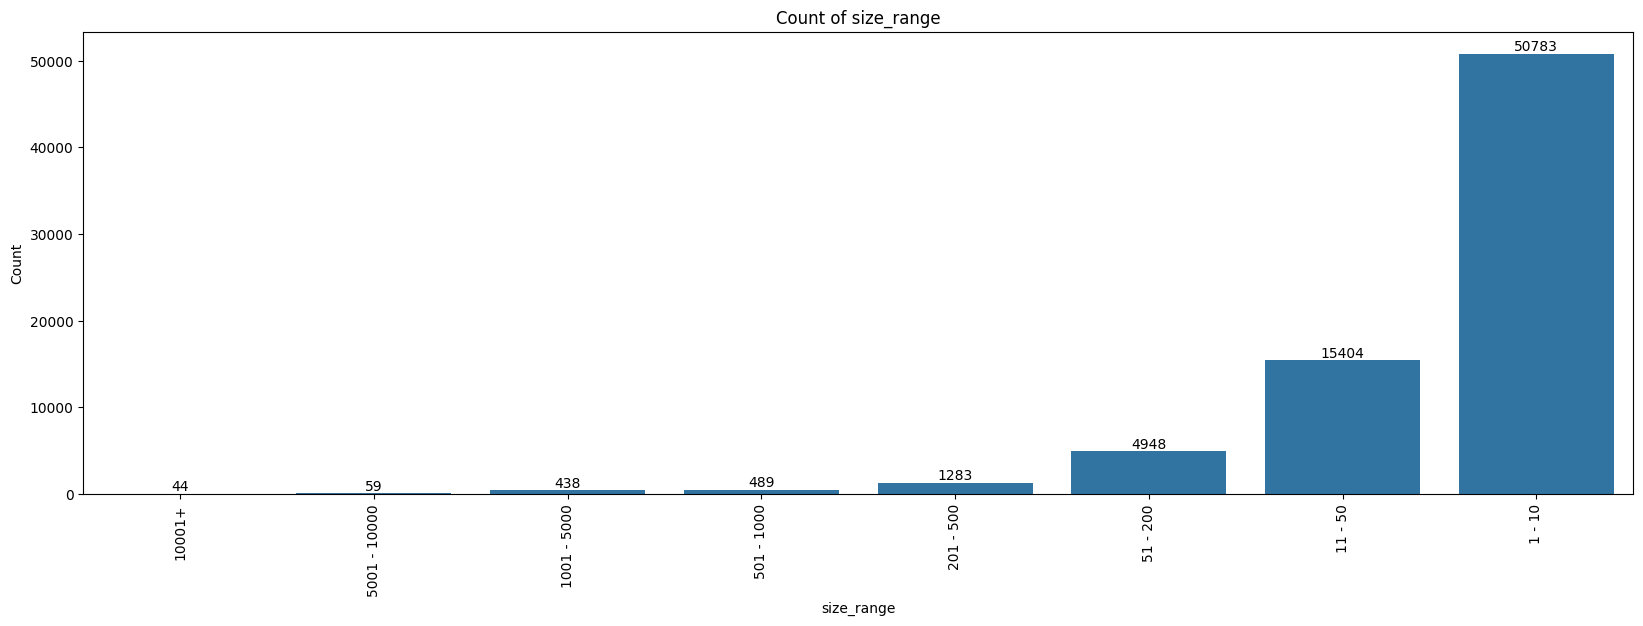

In [27]:
plot_histographs(df_temp, cat_cols)

In [28]:
cat_encoders = {c: LabelEncoder() for c in cat_cols}
encoded_cat_cols = []

for c in cat_cols:
    cat_encoders[c].fit(df_temp[c])
    df_temp[f'{c}_encoded'] = cat_encoders[c].transform(df_temp[c])
    encoded_cat_cols.append(f'{c}_encoded')

/tmp/ipykernel_30383/2006698751.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[f'{c}_encoded'] = cat_encoders[c].transform(df_temp[c])
/tmp/ipykernel_30383/2006698751.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[f'{c}_encoded'] = cat_encoders[c].transform(df_temp[c])
/tmp/ipykernel_30383/2006698751.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

/tmp/ipykernel_30383/1784574348.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['label'] = target_encoder.transform(df_temp[label_col])


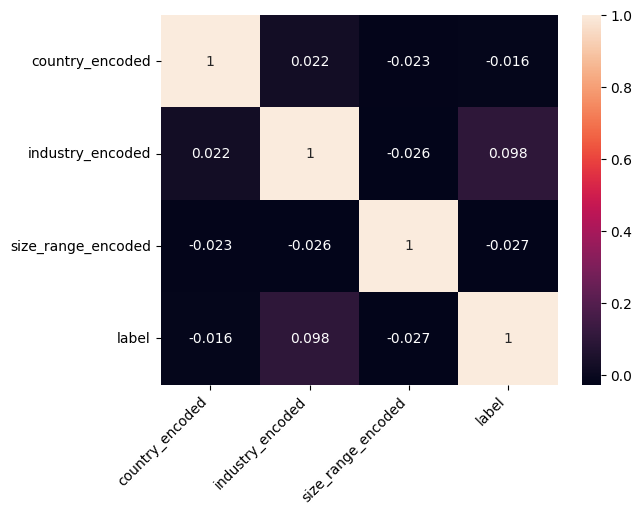

In [29]:
# Add category label to the temporary DataFrame to correlate
df_temp['label'] = target_encoder.transform(df_temp[label_col])

# Get features correlations
corr = df_temp[encoded_cat_cols + ['label']].corr()

# Create correlation matrix as a heatmap
plot = sns.heatmap(corr, annot=True)

# Get x-axis tick locations and labels
xtick_loc, xtick_labels = plt.xticks()

# Set the x-axis ticks
plot.set_xticks(ticks=xtick_loc, labels=xtick_labels, rotation=45, ha='right')

plt.show()

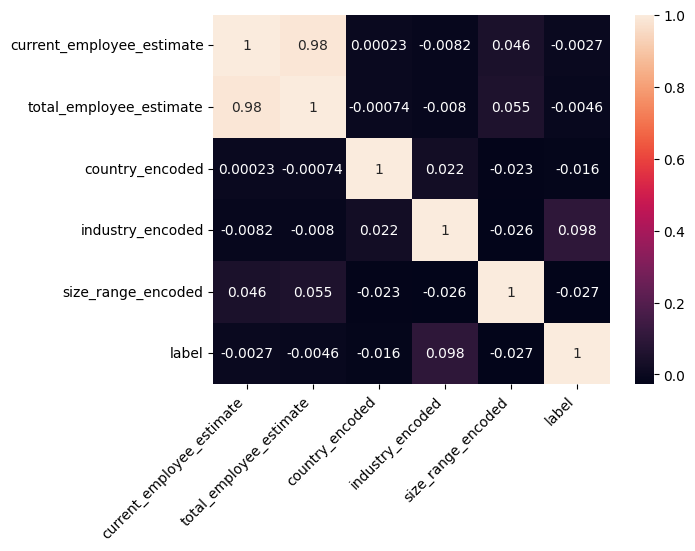

In [30]:
# Get features correlations
corr = df_temp[num_cols + encoded_cat_cols + ['label']].dropna().corr()

# Create correlation matrix as a heatmap
plot = sns.heatmap(corr, annot=True)

# Get x-axis tick locations and labels
xtick_loc, xtick_labels = plt.xticks()

# Set the x-axis ticks
plot.set_xticks(ticks=xtick_loc, labels=xtick_labels, rotation=45, ha='right')

plt.show()

### Explore text features

In [31]:
df_temp = df.dropna(subset=text_cols)

In [32]:
for c in text_cols + ['industry']:
    print(f'Mean {c} length:', df_temp[c].str.len().mean())
    print(f'Max {c} length:', df_temp[c].str.len().max())
    print()

print()

for c in text_cols:
    print(f'Mean {c} number of words:', df_temp[c].apply(lambda x: len(x.split())).mean())
    print(f'Max {c} number of words:', df_temp[c].apply(lambda x: len(x.split())).max())
    print()

Mean homepage_text length: 4615.293293369443
Max homepage_text length: 883048

Mean meta_description length: 196.31718041566504
Max meta_description length: 82976

Mean industry length: 17.804430514560448
Max industry length: 35


Mean homepage_text number of words: 643.7855947418069
Max homepage_text number of words: 81083

Mean meta_description number of words: 28.687338344034323
Max meta_description number of words: 12333



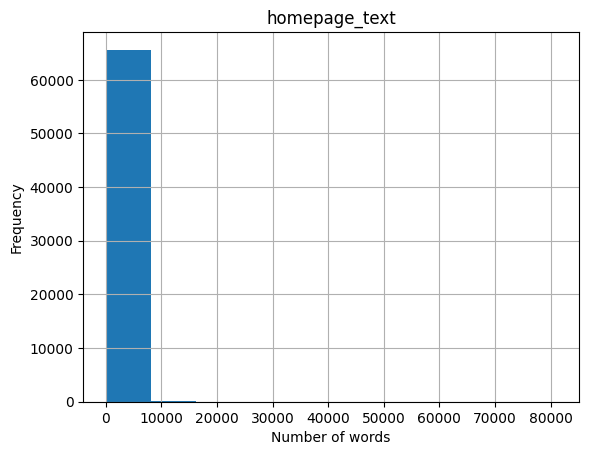

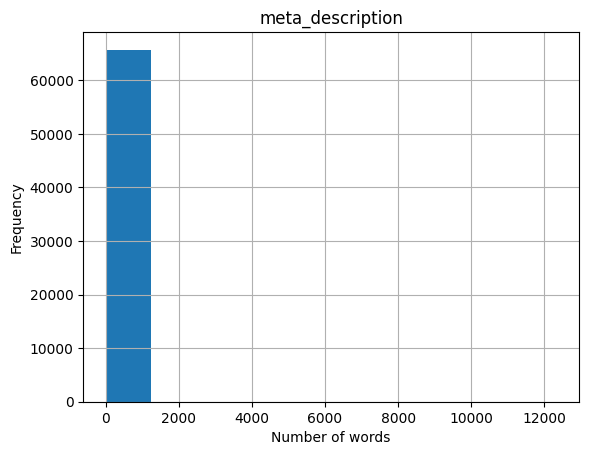

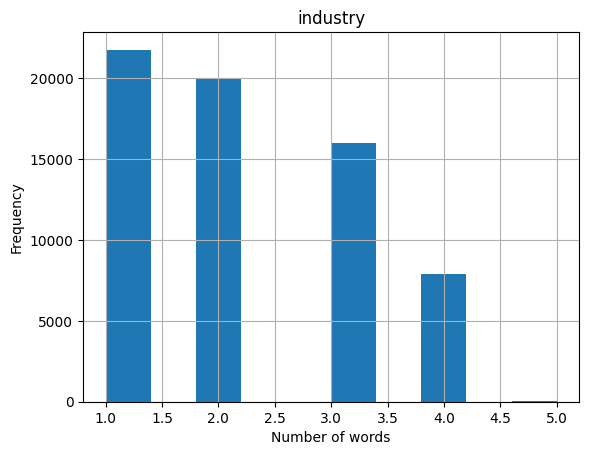

In [33]:
for c in text_cols + ['industry']:
    df_temp[c].str.split().apply(lambda x: len(x)).hist()
    plt.title(c)
    plt.xlabel('Number of words')
    plt.ylabel('Frequency')
    plt.show()

In [37]:
co = CountVectorizer(stop_words=stopwords.words('english'))

for c in text_cols + ['industry']:
    counts = co.fit_transform(df_temp[c])
    print(f'Word frequency for "{c}"')
    print(pd.DataFrame(counts.sum(axis=0), columns=co.get_feature_names_out()).T.sort_values(0, ascending=False).head(25))
    print()
    print()

Word frequency for "homepage_text"
                 0
us          268933
services    193827
contact     168936
home        130560
business    129346
service     111151
insurance   109102
new          95619
read         85323
get          81662
team         79047
learn        74730
solutions    71323
company      70980
help         70794
products     68663
management   67976
work         66738
2020         66037
time         64959
com          62248
care         61897
best         61602
view         61098
00           58491


Word frequency for "meta_description"
                0
services    14338
service      8609
business     8049
solutions    7545
company      7113
sep          6449
insurance    6040
management   5492
us           5193
new          5149
best         4891
quality      4765
design       4607
energy       4529
based        4527
home         4443
today        4364
commercial   4283
marketing    4280
provides     4223
providing    4067
care         4049
call         4041

In [38]:
co = CountVectorizer(ngram_range=(2,2), stop_words=stopwords.words('english'))

for c in text_cols + ['industry']:
    counts = co.fit_transform(df_temp[c])
    print(f'Bi-grams frequency for {c}')
    print(pd.DataFrame(counts.sum(axis=0), columns=co.get_feature_names_out()).T.sort_values(0, ascending=False).head(25))
    print()
    print()

# co = CountVectorizer(ngram_range=(3,3), stop_words=stopwords.words('english'))

# for c in text_cols + ['industry']:
#     counts = co.fit_transform(df_temp[c])
#     print(f'Tri-grams frequency for {c}')
#     print(pd.DataFrame(counts.sum(axis=0), columns=co.get_feature_names_out()).T.sort_values(0, ascending=False).head(50))
#     print()
#     print()

Bi-grams frequency for homepage_text
                      0
contact us        89467
privacy policy    28249
rights reserved   26490
ãƒæ ãƒâ           24681
home us           15169
real estate       14896
call us           14073
customer service  12074
šã ãƒæ            10948
social media      10918
ãƒâ šã            10662
00 pm             10489
terms conditions  10437
us contact         9432
00 00              9148
blog contact       8768
get touch          8528
new york           8333
long term          8175
us today           8151
ãƒâ šâ             8003
copyright 2020     7996
home services      7847
high quality       7475
email address      7449


Bi-grams frequency for meta_description
                           0
full service            2172
real estate             1725
contact us              1311
us today                1293
high quality            1222
call us                 1214
award winning           1082
law firm                1007
years experience         895
new yor

### Finalize - Save the modified dataset for using it in developing AI Model(s)

In [39]:
# Useful input columns for classification
useful_cols = ['industry', 'homepage_text', 'meta_description', 'category']

# Remove rows with missing values in all columns
df = df.dropna(subset=useful_cols, how='all')
df = df.reset_index(drop=True)

# Add a unique row ID
df['id'] = df.index

# Store the dataset for training & evaluating a classifier
df[['id']+useful_cols].to_csv(os.path.join('data', 'dataset.csv'), index=False)